In [1]:
import os
import warnings
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision

from pathlib import Path
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
import json
import re

from model_distances import distance_matrix
from utils import test_model, compare_models_prediction, generate_z_samples
from zoo_utils import load_hyperrep_edx

from shrp.models.def_net import CNN, CNN3
from shrp.models.def_AE_trainable import get_transformations
from shrp.datasets.dataset_auxiliaries import tokens_to_recipe, tokens_to_checkpoint
from shrp.models.def_loss import DistillationLoss, ReconDistillationLoss

/netscratch2/lmeynent/research/structure_vs_behaviour/zoo_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid',
              rc={
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'xtick.bottom': True,
                  'ytick.left': True,
                  'font.family': 'Fira Sans'
              })

COLOURS = [
    '#960018',  # Carmine Red
    '#FED85D',  # Mustard Gold
    '#434384',  # Marian Blue
    '#54B674',  # Emerald Green
    '#D183C9',  # French Mauve
    '#318CE7',  # French Blue
    '#D08000'   # Fulvous Orange
]

## Hyperparameters

In [4]:
RERUN = False

In [5]:
EXPERIMENT_PATH = Path.cwd() / 'results' / 'ablation_beta'

if not EXPERIMENT_PATH.is_dir():
    os.makedirs(EXPERIMENT_PATH)

In [29]:
DATASETS = ['svhn', 'cifar10', 'eurosat']
# DATASETS = ['cifar10']
DATASET_LABELS = {
    'svhn': 'SVHN',
    'cifar10': 'CIFAR-10',
    'eurosat': 'EuroSAT'
}
DS_ORDER = ['SVHN', 'CIFAR-10', 'EuroSAT']
HR_ORDER = ["β = 0.0", "β = 0.1", "β = 0.2", "β = 0.3", "β = 0.4", "β = 0.5"]

In [7]:
# Test set corresponding to the data used to train the model zoo
TESTSET_DS = {ds: torch.load(f'/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/{ds}_train_zoo_relu/dataset.pt')['testset'] for ds in DATASETS}
TESTSET_DL = {ds: torch.utils.data.DataLoader(TESTSET_DS[ds], batch_size=64, shuffle=False) for ds in DATASETS}

# Model zoo
ZOO_PATH = {ds: Path(f'/netscratch2/lmeynent/research/structure_vs_behaviour/results/zoos/{ds}_train_zoo_relu') for ds in DATASETS}
ZOO_DS = {ds: torch.load(ZOO_PATH[ds] / 'dataset_test.pt') for ds in DATASETS}
ZOO_DL = {ds: torch.utils.data.DataLoader(ZOO_DS[ds], batch_size=16, shuffle=False) for ds in DATASETS}

# Threshold used to define models that "perform well"; depends on the zoo
MODEL_ACC_THR = {
    'svhn': 0.8,
    'cifar10': 0.6,
    'eurosat': 0.7
}

# Path to the hyper-representation models
HYPERREP_PATH = {ds: Path(f'/netscratch2/lmeynent/research/structure_vs_behaviour/results/hyperrepresentations/tune/{ds}_train_hyperrep_beta') for ds in DATASETS}

## Loading data

### Loading HR models meta-data

In [8]:
MAX_EPOCH = 100

df_hr = pd.DataFrame(columns=[
    'Model zoo',
    'Trial ID',
    'Learning rate',
    'Latent dimension',
    'Behaviour loss',
    'Query set',
    'Query dataset',
    '# of queries',
    'Gamma',
    'Beta',
    'Epoch',
    'Train loss',
    'Train loss (contrast)', 
    'Train loss (recon)',
    'Train loss (structure)', 
    'Train loss (behaviour)',
    'Test loss',
    'Test loss (contrast)', 
    'Test loss (recon)',
    'Test loss (structure)', 
    'Test loss (behaviour)',
    'Dstk: Test accuracy',
    'Dstk: GGap'
])

for ds in DATASETS:
    for path in os.listdir(HYPERREP_PATH[ds]):
        if not re.match('AE_trainable', path):
            continue
        path = HYPERREP_PATH[ds] / path

        with open(path / 'params.json') as ifh_config, open(path / 'result.json') as ifh_result:
            config = json.load(ifh_config)
            result = pd.read_json(ifh_result, lines=True, dtype={'trial_id': str})

        for edx in range(len(result)):
            df_hr.loc[len(df_hr)] = (
                DATASET_LABELS[ds],
                result.loc[edx]['trial_id'],
                config['optim::lr'],
                config['ae:lat_dim'],
                config['training::loss_distillation'],
                config['training::queryset_distillation'],
                config['training::queryset_dump'],
                config['training::n_queries_distillation'],
                config['training::gamma'],
                config['training::beta'],
                result.loc[edx]['training_iteration'],
                result.loc[edx]['loss/loss_train'],
                result.loc[edx]['loss/loss_contrast_train'],
                result.loc[edx]['loss/loss_recon_train'],
                result.loc[edx]['loss/loss_structure_train'],
                result.loc[edx]['loss/loss_behaviour_train'],
                result.loc[edx]['loss/loss_test'],
                result.loc[edx]['loss/loss_contrast_test'],
                result.loc[edx]['loss/loss_recon_test'],
                result.loc[edx]['loss/loss_structure_test'],
                result.loc[edx]['loss/loss_behaviour_test'],
                result.loc[edx]['dstk/test_acc_test'],
                result.loc[edx]['dstk/ggap_test']
            )

df_hr['Query dataset'] = df_hr['Query dataset'].map({
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/svhn_train_zoo_relu/dataset.pt': 'SVHN',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/cifar10_train_zoo_relu/dataset.pt': 'CIFAR-10',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/eurosat_train_zoo_relu/dataset.pt': 'EuroSAT',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/tinyimagenet_32/dataset.pt': 'TinyImagenet_32',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/stl10_32/dataset.pt': 'STL-10_32'
})
df_hr.head()

,Model zoo,Trial ID,Learning rate,Latent dimension,Behaviour loss,Query set,Query dataset,# of queries,Gamma,Beta,...,Train loss (recon),Train loss (structure),Train loss (behaviour),Test loss,Test loss (contrast),Test loss (recon),Test loss (structure),Test loss (behaviour),Dstk: Test accuracy,Dstk: GGap
0,SVHN,57f49_00005,0.00001,64,l2,data,SVHN,256,0.05,0.5,...,0.945427,0.938290,0.952565,0.882474,1.051165,0.873595,0.796746,0.950444,0.559680,0.283559
1,SVHN,57f49_00005,0.00001,64,l2,data,SVHN,256,0.05,0.5,...,0.551571,0.651074,0.452067,0.490320,0.809172,0.473538,0.491274,0.455802,0.529307,0.283584
2,SVHN,57f49_00005,0.00001,64,l2,data,SVHN,256,0.05,0.5,...,0.544532,0.638370,0.450693,0.495229,0.612573,0.489053,0.516385,0.461721,0.529392,0.294863
3,SVHN,57f49_00005,0.00001,64,l2,data,SVHN,256,0.05,0.5,...,0.547073,0.643338,0.450809,0.490010,0.556766,0.486497,0.514237,0.458757,0.525779,0.291382
4,SVHN,57f49_00005,0.00001,64,l2,data,SVHN,256,0.05,0.5,...,0.531599,0.610236,0.452962,0.479066,0.615966,0.471861,0.483011,0.460710,0.552940,0.294685


### Loading checkpoints

In [9]:
# Loading hyper-reps
def load_hr(trial_id):
    for ds in DATASETS:
        for path in os.listdir(HYPERREP_PATH[ds]):
            if trial_id in path:
                return load_hyperrep_edx(HYPERREP_PATH[ds] / path, MAX_EPOCH)

hyper_reps = {idx: load_hr(idx) for idx in df_hr['Trial ID'].unique()}

In [10]:
# Loading reference config
trial_id = df_hr.iloc[0]['Trial ID']
for path in os.listdir(HYPERREP_PATH['svhn']):
    if trial_id in path:
        model_path = HYPERREP_PATH['svhn'] / path
        with open(HYPERREP_PATH['svhn'] / path / 'params.json') as ifh:
            ref_config = json.load(ifh)

# Loading reference params
ref_path = ref_config["training::distil_reference"]
with open(os.path.join(ref_path, 'params.json')) as ifh:
    reference_params = json.load(ifh)
    
# Loading reference checkpoint
ref_chkpth = None
for chkpth in os.listdir(ref_path):
    if 'checkpoint_' in chkpth:
        if not ref_chkpth or int(chkpth.split('_')[-1]) > int(ref_chkpth.split('_')[-1]):
            ref_chkpth = chkpth

reference_checkpoint = torch.load(Path(ref_path) / str(ref_chkpth) / 'checkpoints', map_location=torch.device("cpu"))
reference_checkpoint_cuda = {k: v.to('cuda') for k, v in deepcopy(reference_checkpoint).items()}

### Extracting key models

In [11]:
df_hr[(df_hr['Epoch'] == MAX_EPOCH)]

,Model zoo,Trial ID,Learning rate,Latent dimension,Behaviour loss,Query set,Query dataset,# of queries,Gamma,Beta,...,Train loss (recon),Train loss (structure),Train loss (behaviour),Test loss,Test loss (contrast),Test loss (recon),Test loss (structure),Test loss (behaviour),Dstk: Test accuracy,Dstk: GGap
100,SVHN,57f49_00005,0.00001,64,l2,data,SVHN,256,0.05,0.5,...,0.342051,0.568489,0.115613,0.299955,0.345813,0.297542,0.454882,0.140201,0.684750,0.328016
201,SVHN,57f49_00002,0.00001,64,l2,data,SVHN,256,0.05,0.2,...,0.224265,0.656366,0.116240,0.223473,0.329193,0.217909,0.526438,0.140776,0.596859,0.310136
302,SVHN,57f49_00001,0.00001,64,l2,data,SVHN,256,0.05,0.1,...,0.109334,0.708302,0.042782,0.106199,0.294741,0.096276,0.594467,0.040921,0.896786,0.368863
403,SVHN,57f49_00003,0.00001,64,l2,data,SVHN,256,0.05,0.3,...,0.257184,0.576627,0.120280,0.246796,0.334406,0.242185,0.467068,0.145807,0.594095,0.322997
504,SVHN,57f49_00004,0.00001,64,l2,data,SVHN,256,0.05,0.4,...,0.336002,0.668076,0.114620,0.301667,0.339042,0.299700,0.540916,0.138889,0.652349,0.327591
605,SVHN,57f49_00000,0.00001,64,l2,data,SVHN,256,0.05,0.0,...,0.486744,0.000000,0.486744,0.485057,0.223004,0.498849,0.000000,0.498849,0.763858,0.333145
706,CIFAR-10,c0ef5_00003,0.00001,64,l2,data,STL-10_32,256,0.05,0.3,...,0.311229,0.815522,0.095104,0.263618,0.299442,0.261733,0.646032,0.097033,0.937839,0.744785
807,CIFAR-10,c0ef5_00004,0.00001,64,l2,data,STL-10_32,256,0.05,0.4,...,0.303287,0.615933,0.094857,0.256411,0.304050,0.253903,0.485431,0.099551,0.934207,0.749801
908,CIFAR-10,c0ef5_00000,0.00001,64,l2,data,STL-10_32,256,0.05,0.0,...,0.300401,0.000000,0.300401,0.297321,0.224011,0.301180,0.000000,0.301180,0.916777,0.761906
1009,CIFAR-10,c0ef5_00005,0.00001,64,l2,data,STL-10_32,256,0.05,0.5,...,0.428047,0.745534,0.110560,0.351814,0.339982,0.352437,0.587414,0.117460,0.918251,0.761250


In [33]:
IDX_DICT = {ds:
    {
        df_hr[(df_hr['Model zoo'] == DATASET_LABELS[ds]) & (df_hr['Beta'] == 0.0)]['Trial ID'].iloc[0]: "β = 0.0",
        df_hr[(df_hr['Model zoo'] == DATASET_LABELS[ds]) & (df_hr['Beta'] == 0.1)]['Trial ID'].iloc[0]: "β = 0.1",
        df_hr[(df_hr['Model zoo'] == DATASET_LABELS[ds]) & (df_hr['Beta'] == 0.2)]['Trial ID'].iloc[0]: "β = 0.2",
        df_hr[(df_hr['Model zoo'] == DATASET_LABELS[ds]) & (df_hr['Beta'] == 0.3)]['Trial ID'].iloc[0]: "β = 0.3",
        df_hr[(df_hr['Model zoo'] == DATASET_LABELS[ds]) & (df_hr['Beta'] == 0.4)]['Trial ID'].iloc[0]: "β = 0.4",
        df_hr[(df_hr['Model zoo'] == DATASET_LABELS[ds]) & (df_hr['Beta'] == 0.5)]['Trial ID'].iloc[0]: "β = 0.5",
    }
    for ds in DATASETS
}
IDX_DICT

{'svhn': {'57f49_00000': 'β = 0.0',
  '57f49_00001': 'β = 0.1',
  '57f49_00002': 'β = 0.2',
  '57f49_00003': 'β = 0.3',
  '57f49_00004': 'β = 0.4',
  '57f49_00005': 'β = 0.5'},
 'cifar10': {'c0ef5_00000': 'β = 0.0',
  'c0ef5_00001': 'β = 0.1',
  'c0ef5_00002': 'β = 0.2',
  'c0ef5_00003': 'β = 0.3',
  'c0ef5_00004': 'β = 0.4',
  'c0ef5_00005': 'β = 0.5'},
 'eurosat': {'e3743_00000': 'β = 0.0',
  'e3743_00001': 'β = 0.1',
  'e3743_00002': 'β = 0.2',
  'e3743_00003': 'β = 0.3',
  'e3743_00004': 'β = 0.4',
  'e3743_00005': 'β = 0.5'}}

In [39]:
df_hr['Hyper-representation'] = df_hr['Trial ID'].map({k: v for ds_dict in IDX_DICT.values() for k, v in ds_dict.items()})

## Analysing loss

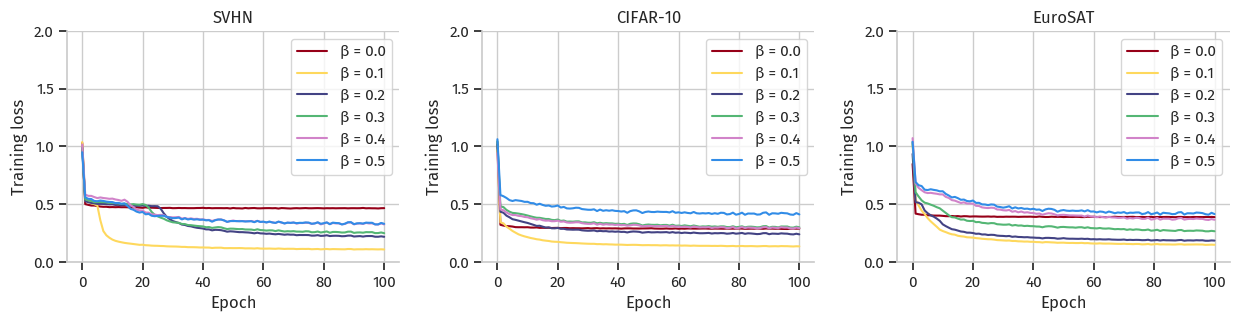

In [13]:
_, axs = plt.subplots(1, len(DATASETS), figsize=(5*len(DATASETS), 3))

if not hasattr(axs, '__getitem__'):
    axs = [axs]

for d, ds in enumerate(DATASETS):
    ds_label = DATASET_LABELS[ds]
    
    for i, (idx, label) in enumerate(IDX_DICT[ds].items()):
        sns.lineplot(df_hr[df_hr['Trial ID'] == idx], x='Epoch', y='Train loss', color=COLOURS[i], label=label, ax=axs[d])
    
    axs[d].set(title=f"{ds_label}", ylabel='Training loss', ylim=(0., 2.))

plt.subplots_adjust(hspace=0.6, wspace=0.25)
plt.show()

## Analysing discriminative downstream tasks

### Test accuracy

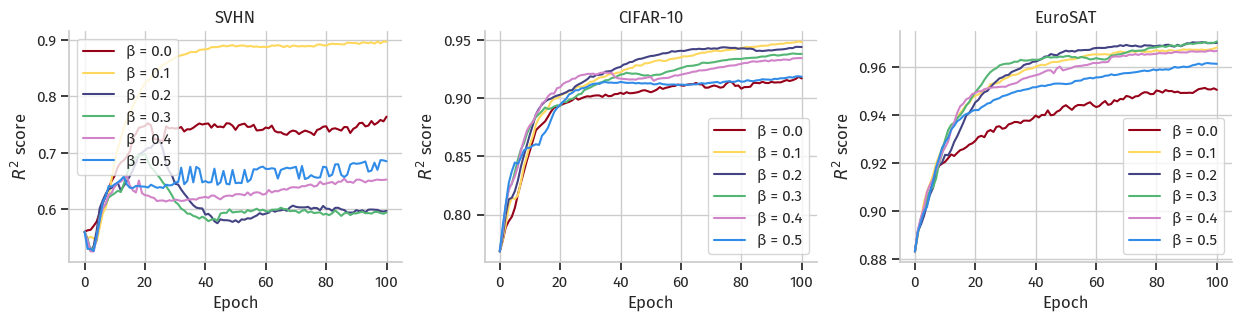

In [14]:
_, axs = plt.subplots(1, len(DATASETS), figsize=(5*len(DATASETS), 3))

if not hasattr(axs, '__getitem__'):
    axs = [axs]

for d, ds in enumerate(DATASETS):
    ds_label = DATASET_LABELS[ds]
    
    for i, (idx, label) in enumerate(IDX_DICT[ds].items()):
        sns.lineplot(df_hr[df_hr['Trial ID'] == idx], x='Epoch', y='Dstk: Test accuracy', color=COLOURS[i], label=label, ax=axs[d])
    
    axs[d].set(title=f"{ds_label}", ylabel='$R^2$ score')

plt.subplots_adjust(hspace=0.6, wspace=0.25)
plt.show()

### Generalisation gap

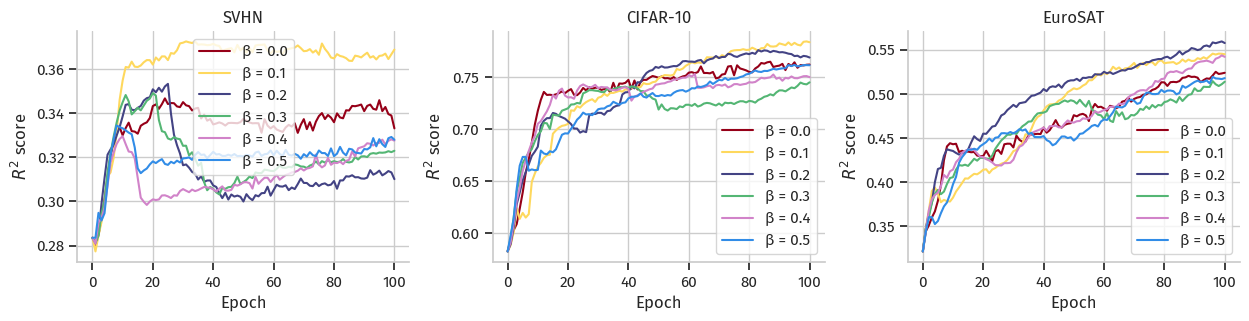

In [15]:
_, axs = plt.subplots(1, len(DATASETS), figsize=(5*len(DATASETS), 3))

if not hasattr(axs, '__getitem__'):
    axs = [axs]

for d, ds in enumerate(DATASETS):
    ds_label = DATASET_LABELS[ds]
    
    for i, (idx, label) in enumerate(IDX_DICT[ds].items()):
        sns.lineplot(df_hr[df_hr['Trial ID'] == idx], x='Epoch', y='Dstk: GGap', color=COLOURS[i], label=label, ax=axs[d])
    
    axs[d].set(title=f"{ds_label}", ylabel='$R^2$ score')

plt.subplots_adjust(hspace=0.6, wspace=0.25)
plt.show()

### Combined

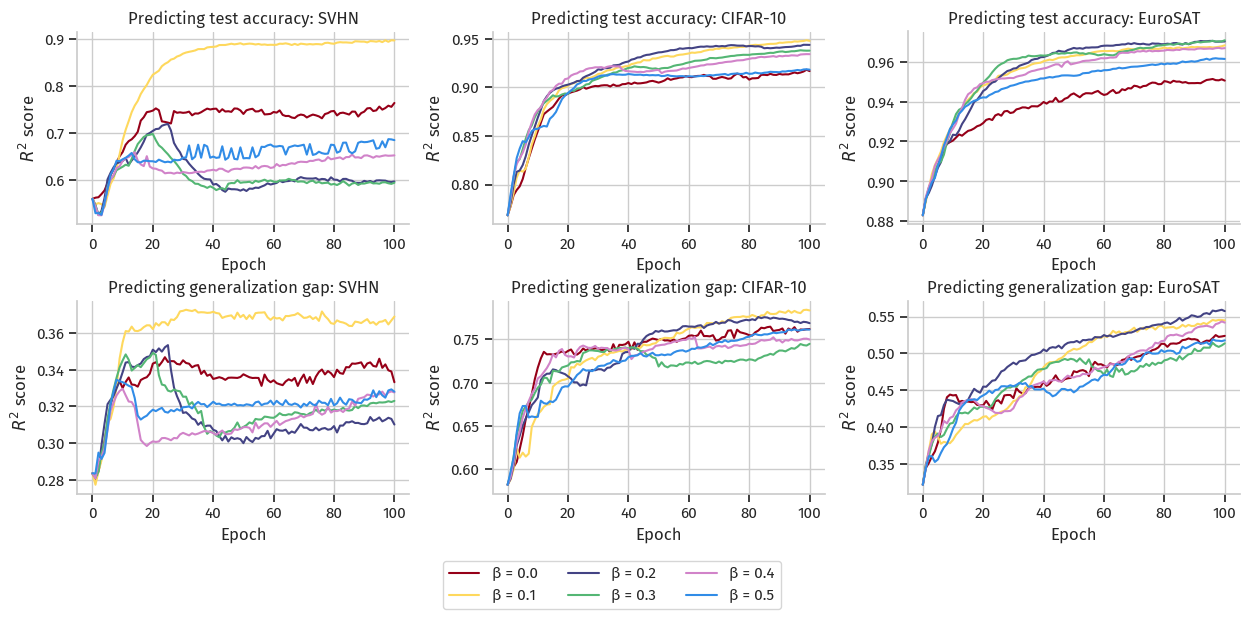

In [16]:
_, axs = plt.subplots(2, len(DATASETS), figsize=(5*len(DATASETS), 6))

if not hasattr(axs[0], '__getitem__'):
    axs = [[ax] for ax in axs]

for d, ds in enumerate(DATASETS):
    ds_label = DATASET_LABELS[ds]
    
    for i, (idx, label) in enumerate(IDX_DICT[ds].items()):
        plot_label = 'Zoo trainset' if label == DATASET_LABELS[ds] else label
        sns.lineplot(df_hr[df_hr['Trial ID'] == idx], x='Epoch', y='Dstk: Test accuracy', color=COLOURS[i], label=plot_label, ax=axs[0][d])
        sns.lineplot(df_hr[df_hr['Trial ID'] == idx], x='Epoch', y='Dstk: GGap', color=COLOURS[i], label=plot_label, ax=axs[1][d])
    
    axs[0][d].set(title=f"Predicting test accuracy: {ds_label}", ylabel='$R^2$ score')
    axs[0][d].legend().remove()
    
    axs[1][d].set(title=f"Predicting generalization gap: {ds_label}", ylabel='$R^2$ score')
    axs[1][d].legend().remove()

plt.legend(ncols=3, loc=(-1.40, -0.60))
plt.subplots_adjust(hspace=0.4, wspace=0.25)
plt.savefig('figures/queryset_discriminative.png', dpi=300, bbox_inches='tight')
plt.show()

### Table

In [46]:
df_dstk = df_hr[df_hr['Epoch'] == MAX_EPOCH]
df_dstk = df_dstk.groupby(['Hyper-representation', 'Model zoo'])['Dstk: Test accuracy'].mean().reset_index().pivot(index='Hyper-representation', columns='Model zoo', values='Dstk: Test accuracy')
df_dstk = df_dstk.loc[HR_ORDER, DS_ORDER]
df_dstk = df_dstk.style.format(precision=3)
print(df_dstk.to_latex())
df_dstk

\begin{tabular}{lrrr}
Model zoo & SVHN & CIFAR-10 & EuroSAT \\
Hyper-representation &  &  &  \\
β = 0.0 & 0.764 & 0.917 & 0.950 \\
β = 0.1 & 0.897 & 0.948 & 0.968 \\
β = 0.2 & 0.597 & 0.944 & 0.970 \\
β = 0.3 & 0.594 & 0.938 & 0.971 \\
β = 0.4 & 0.652 & 0.934 & 0.967 \\
β = 0.5 & 0.685 & 0.918 & 0.961 \\
\end{tabular}



Model zoo,SVHN,CIFAR-10,EuroSAT
Hyper-representation,,,
β = 0.0,0.764,0.917,0.950
β = 0.1,0.897,0.948,0.968
β = 0.2,0.597,0.944,0.970
β = 0.3,0.594,0.938,0.971
β = 0.4,0.652,0.934,0.967
β = 0.5,0.685,0.918,0.961


In [47]:
df_dstk = df_hr[df_hr['Epoch'] == MAX_EPOCH]
df_dstk = df_dstk.groupby(['Hyper-representation', 'Model zoo'])['Dstk: GGap'].mean().reset_index().pivot(index='Hyper-representation', columns='Model zoo', values='Dstk: GGap')
df_dstk = df_dstk.loc[HR_ORDER, DS_ORDER]
df_dstk = df_dstk.style.format(precision=3)
print(df_dstk.to_latex())
df_dstk

\begin{tabular}{lrrr}
Model zoo & SVHN & CIFAR-10 & EuroSAT \\
Hyper-representation &  &  &  \\
β = 0.0 & 0.333 & 0.762 & 0.524 \\
β = 0.1 & 0.369 & 0.783 & 0.545 \\
β = 0.2 & 0.310 & 0.769 & 0.557 \\
β = 0.3 & 0.323 & 0.745 & 0.514 \\
β = 0.4 & 0.328 & 0.750 & 0.542 \\
β = 0.5 & 0.328 & 0.761 & 0.518 \\
\end{tabular}



Model zoo,SVHN,CIFAR-10,EuroSAT
Hyper-representation,,,
β = 0.0,0.333,0.762,0.524
β = 0.1,0.369,0.783,0.545
β = 0.2,0.310,0.769,0.557
β = 0.3,0.323,0.745,0.514
β = 0.4,0.328,0.750,0.542
β = 0.5,0.328,0.761,0.518


## Analysing reconstructive downstream tasks

In [17]:
def compute_reconstruction_acc(hr, x, p, i, dataloader):
    z, y, zp = hr.forward(x, p)
    checkpoint = tokens_to_checkpoint(y[i], p[i], reference_checkpoint)
    model = CNN3(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return test_model(model, dataloader, device='cuda')

In [19]:
DF_ZOO_ACC_PATH = EXPERIMENT_PATH / 'df_zoo_acc.csv'
DF_Z_PATH = EXPERIMENT_PATH / 'df_z_dict.csv'
DF_X_PATH = EXPERIMENT_PATH / 'df_x_dict.csv'

X_DIM_1, X_DIM_2 = next(iter(ZOO_DL['cifar10']))[0].shape[1:3]
X_COLS = [f'Dimension {i}' for i in range(X_DIM_1 * X_DIM_2)]

Z_DIM_1 = X_DIM_1
Z_DIM_2 = 64
Z_COLS = [f'Dimension {i}' for i in range(Z_DIM_1 * Z_DIM_2)]

if not DF_ZOO_ACC_PATH.is_file() or RERUN:
    # Create dataframe
    df_zoo_acc = pd.DataFrame(columns=['Model zoo', 'Model index', 'Hyper-representation', 'Hyper-representation model', 'Original accuracy', 'Reconstruction accuracy'])
    df_x = pd.DataFrame(columns=['Model zoo', 'Model index', 'Hyper-representation', 'Hyper-representation model'] + X_COLS)
    df_z = pd.DataFrame(columns=['Model zoo', 'Model index', 'Hyper-representation', 'Hyper-representation model'] + Z_COLS)

    # Run experiments
    for ds in DATASETS:
        for bdx, data in enumerate(tqdm(ZOO_DL[ds])):
            x, m, p, _ = [tensor.to('cuda') for tensor in data]
            orig_acc = []
            
            for idx in range(x.shape[0]):
                # Original accuracy
                orig_checkpoint = tokens_to_checkpoint(x[idx], p[idx], reference_checkpoint)
                orig_model = CNN3(
                    channels_in=reference_params['model::channels_in'],
                    nlin=reference_params['model::nlin'],
                    dropout=reference_params['model::dropout']
                )
                orig_model.load_state_dict(orig_checkpoint)
                orig_acc.append(test_model(orig_model, TESTSET_DL[ds]))

            for hr_idx, hr_label in IDX_DICT[ds].items():
                
                z, y, _ = hyper_reps[hr_idx].to('cuda').forward(x, p)

                for idx in range(x.shape[0]):
                    # Reconstruction accuracy
                    recon_checkpoint = tokens_to_checkpoint(y[idx], p[idx], reference_checkpoint)
                    recon_model = CNN3(
                        channels_in=reference_params['model::channels_in'],
                        nlin=reference_params['model::nlin'],
                        dropout=reference_params['model::dropout']
                    )
                    recon_model.load_state_dict(recon_checkpoint)
                    recon_acc = test_model(recon_model, TESTSET_DL[ds])

                    # Save results to DataFrame
                    mdx = bdx * x.shape[0] + idx
                    df_zoo_acc.loc[len(df_zoo_acc)] = (
                        DATASET_LABELS[ds],
                        mdx,
                        hr_idx,
                        hr_label,
                        orig_acc[idx],
                        recon_acc
                    )
                    df_x.loc[len(df_x)] = [DATASET_LABELS[ds], mdx, hr_idx, hr_label] + x[idx].flatten().tolist()
                    df_z.loc[len(df_z)] = [DATASET_LABELS[ds], mdx, hr_idx, hr_label] + z[idx].flatten().tolist()

    # Save results to disk
    df_zoo_acc.to_csv(DF_ZOO_ACC_PATH)
    df_x.to_csv(DF_X_PATH)
    df_z.to_csv(DF_Z_PATH)
    
df_zoo_acc = pd.read_csv(DF_ZOO_ACC_PATH, index_col=0)
df_x = pd.read_csv(DF_X_PATH, index_col=0)
df_z = pd.read_csv(DF_Z_PATH, index_col=0)
df_zoo_acc.head()

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

,Model zoo,Model index,Hyper-representation,Hyper-representation model,Original accuracy,Reconstruction accuracy
0,SVHN,0,57f49_00000,β = 0.0,0.743623,0.195874
1,SVHN,1,57f49_00000,β = 0.0,0.828596,0.195874
2,SVHN,2,57f49_00000,β = 0.0,0.856215,0.195874
3,SVHN,3,57f49_00000,β = 0.0,0.873848,0.195874
4,SVHN,4,57f49_00000,β = 0.0,0.887792,0.195874


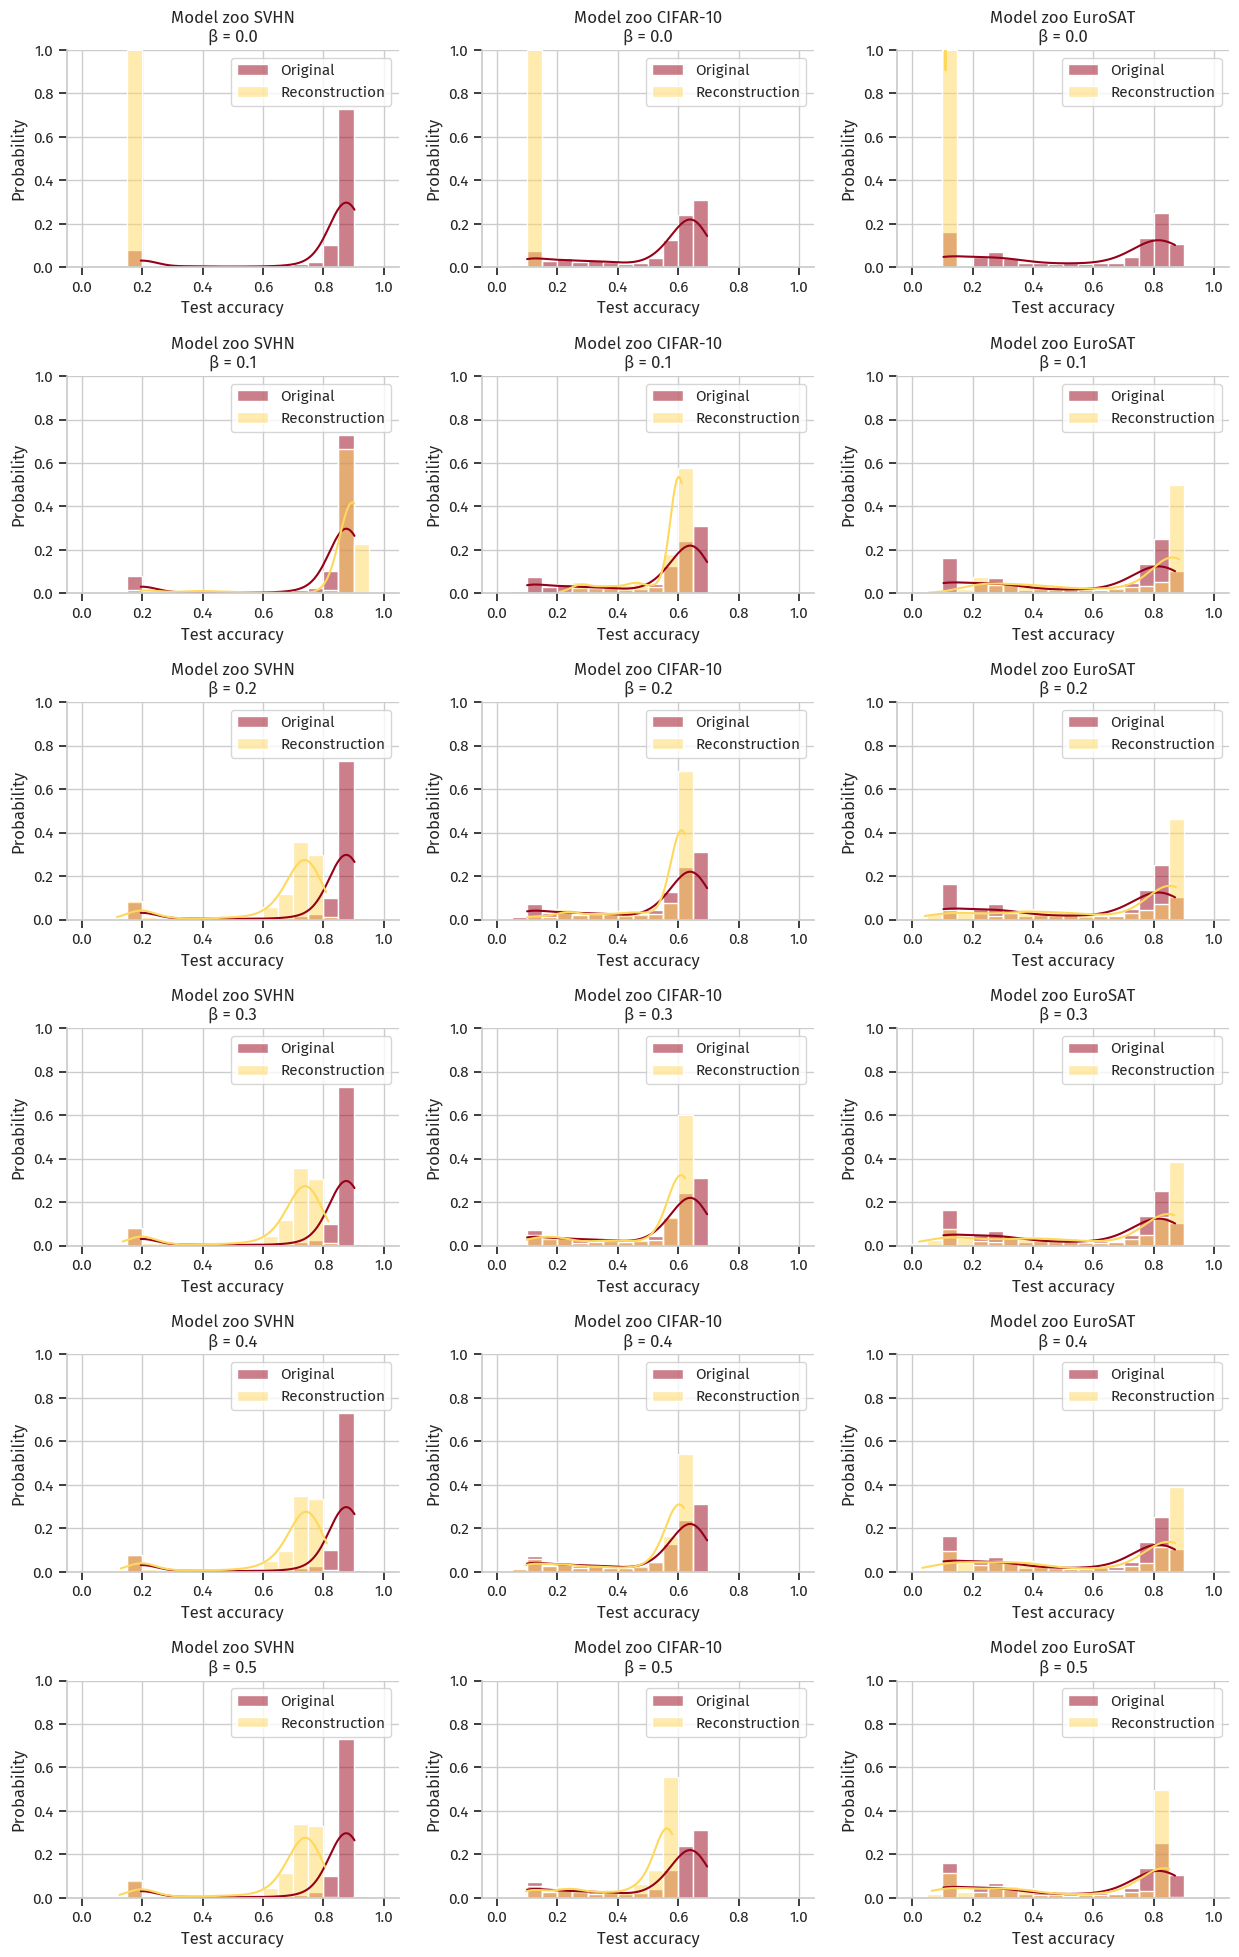

In [20]:
_, axs = plt.subplots(len(IDX_DICT['cifar10']), len(DATASETS), figsize=(5*len(DATASETS), 4*len(IDX_DICT['cifar10'])))

if not hasattr(axs[0], '__getitem__'):
    axs = [[ax] for ax in axs]

for d, ds in enumerate(DATASETS):
    for i, (idx, label) in enumerate(IDX_DICT[ds].items()):
        sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation'] == idx], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[i][d])
        sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation'] == idx], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstruction', ax=axs[i][d])
        axs[i][d].set(title=f"Model zoo {DATASET_LABELS[ds]}\n{label}", xlabel='Test accuracy', ylabel='Probability', ylim=(0, 1))
        axs[i][d].legend()
    
plt.subplots_adjust(hspace=0.5, wspace=0.25)
plt.show()

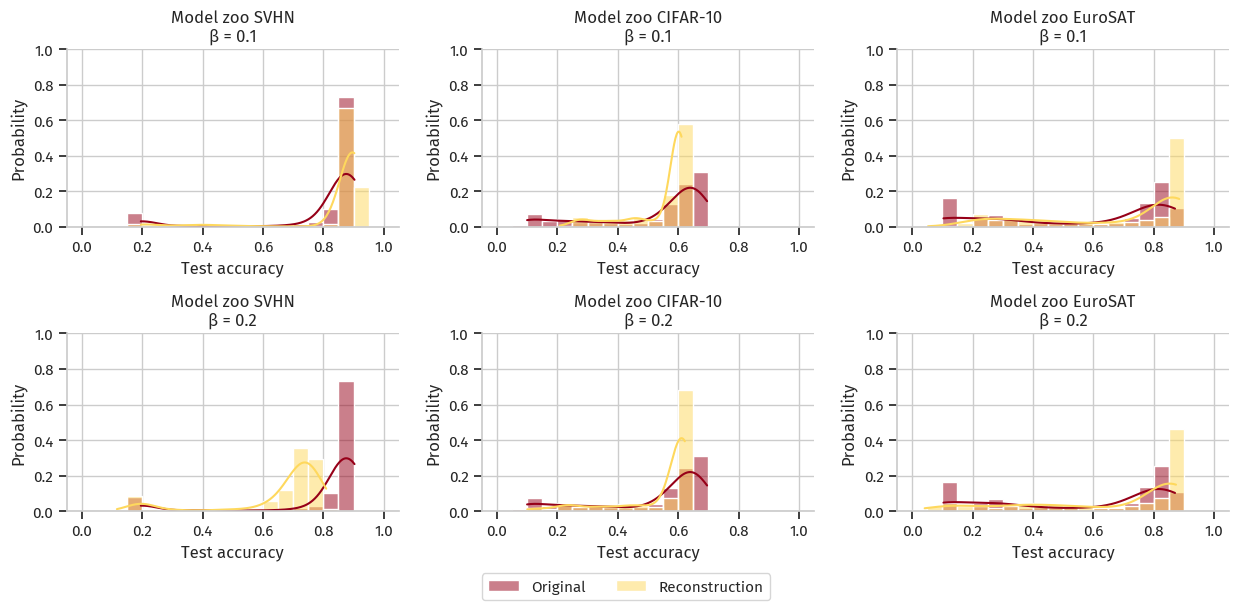

In [53]:
_, axs = plt.subplots(2, len(DATASETS), figsize=(5*len(DATASETS), 6))

if not hasattr(axs[0], '__getitem__'):
    axs = [[ax] for ax in axs]

for d, ds in enumerate(DATASETS):
    for idx, label in IDX_DICT[ds].items():
        if label == "β = 0.1":
            i = 0
        elif label == "β = 0.2":
            i = 1
        else:
            continue
        
        sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation'] == idx], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[i][d])
        sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation'] == idx], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstruction', ax=axs[i][d])
        axs[i][d].set(title=f"Model zoo {DATASET_LABELS[ds]}\n{label}", xlabel='Test accuracy', ylabel='Probability', ylim=(0, 1))
        axs[i][d].legend().remove()

# Get the legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Remove extra handle and label
handles = handles[:2]
labels = labels[:2]

plt.legend(handles, labels, loc=(-1.25, -0.50), ncols=2)
plt.subplots_adjust(hspace=0.6, wspace=0.25)
plt.savefig('figures/beta_reconstructive.png', dpi=300, bbox_inches='tight')
plt.show()